# Goal

The goal of this notebook is to train a 3d UNET segmentation model to output binary mask representing the sella turcica ROI.

Notes:
- following https://github.com/kbressem/faimed3d/blob/main/examples/3d_segmentation.md

In [1]:
# Check GPU stats

from pynvml import *
nvmlInit()
try:
    deviceCount = nvmlDeviceGetCount()
    for i in range(deviceCount):
        handle = nvmlDeviceGetHandleByIndex(i)
        print("Device", i, ":", nvmlDeviceGetName(handle))
except NVMLError as error:
    print(error)

Device 0 : b'GeForce GTX 1080 Ti'
Device 1 : b'GeForce GTX 1080'


In [24]:
# Get path to 4 TB HD

# /media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a/home

# wsl: /home/rgologorsky/DeepPit
hd_path = "../" * 5 + "/media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a" + "/home/" + "rachel/PitMRdata"

# all folders in HD
all_folders = os.listdir(hd_path)

print(all_folders)

['ABIDE', 'samir_labels']


In [31]:
#from faimed3d.all import *
from torchvision.models.video import r3d_18
from fastai.callback.all import SaveModelCallback
from torch import nn

import os
import time
import pickle
from pathlib import Path

import SimpleITK as sitk

import numpy as np
import pandas as pd
from pandas import DataFrame as DF

from helpers_preprocess import get_data_dict
from helpers_general import sitk2np, print_sitk_info, round_tuple, lrange, lmap, get_roi_range, numbers2groups

In [35]:
data_dict = get_data_dict(f"{hd_path}/samir_labels/50155-50212/")

In [ ]:
# Reference frame:  [191, 268, 268] 2 [0. 0. 0.] [1. 1. 1.] [1. 0. 0. 0. 1. 0. 0. 0. 1.] [ 95.5 134.  134. ]
# Reference center:  [ 95.5 134.  134. ]

# Training Data - ABIDE

In [3]:
# wsl: /home/rgologorsky/DeepPit
hd_path = "../../../mnt/d/PitMRdata"

# folders with data
data_folders = ["ABIDE", "ABVIB", "ACRIN-FMISO-Brain", "ADNI", "PPMI"]

# unpickle
folder = "ABIDE"
data_df = pd.read_pickle(f"./{folder}-filtered.pkl")
data_df

,folder,imputedSeq,fn,sz,px,sp,dir
0,ABIDE,T1,../../../mnt/d/PitMRdata/ABIDE/PAD/PAD_0001/T1-FFE/1995-03-11_00_00_00.0/S7478/PAD_PAD_0001_MRI_T1-FFE_br_20050224102413918_S7478_I3989.img,"(164, 256, 256)",16-bit signed integer,"(1.0, 1.0, 1.0)","(1, 0, 0, 0, 1, 0, 0, 0, 1)"
1,ABIDE,T1,../../../mnt/d/PitMRdata/ABIDE/PAD/PAD_0002/T1-FFE/1995-04-04_00_00_00.0/S7479/PAD_PAD_0002_MRI_T1-FFE_br_20050224103150454_S7479_I3990.img,"(174, 256, 256)",16-bit signed integer,"(1.0, 1.0, 1.0)","(1, 0, 0, 0, 1, 0, 0, 0, 1)"
2,ABIDE,T1,../../../mnt/d/PitMRdata/ABIDE/PAD/PAD_0003/T1-FFE/1995-03-18_00_00_00.0/S7480/PAD_PAD_0003_MRI_T1-FFE_br_20050224184803115_S7480_I4020.img,"(170, 256, 256)",16-bit signed integer,"(1.0, 1.0, 1.0)","(1, 0, 0, 0, 1, 0, 0, 0, 1)"
3,ABIDE,MPR,../../../mnt/d/PitMRdata/ABIDE/ABIDE_1/50383/MP-RAGE/2000-01-01_00_00_00.0/S164289/ABIDE_50383_MRI_MP-RAGE_br_raw_20120830144726637_S164289_I328282.nii,"(256, 256, 124)",16-bit signed integer,"(1.02, 1.02, 1.2)","(1, 0, 0, 0, -1, 0, 0, 0, 1)"
4,ABIDE,MPR,../../../mnt/d/PitMRdata/ABIDE/ABIDE_1/50412/MP-RAGE/2000-01-01_00_00_00.0/S164292/ABIDE_50412_MRI_MP-RAGE_br_raw_20120830145148127_S164292_I328285.nii,"(106, 256, 256)",16-bit signed integer,"(1.4, 1.0, 1.0)","(1, 0, 0, 0, -1, 0, 0, 0, 1)"
...,...,...,...,...,...,...,...
1048,ABIDE,MPR,../../../mnt/d/PitMRdata/ABIDE/ABIDE/51170/MP-RAGE/2000-01-01_00_00_00.0/S166154/ABIDE_51170_MRI_MP-RAGE_br_raw_20120905101352432_S166154_I330333.nii,"(256, 132, 256)",16-bit signed integer,"(0.86, 1.5, 0.86)","(1, 0, 0, 0, -1, 0, 0, 0, 1)"
1049,ABIDE,MPR,../../../mnt/d/PitMRdata/ABIDE/ABIDE/51172/MP-RAGE/2000-01-01_00_00_00.0/S166155/ABIDE_51172_MRI_MP-RAGE_br_raw_20120905101431139_S166155_I330334.nii,"(256, 132, 256)",16-bit signed integer,"(0.86, 1.5, 0.86)","(1, 0, 0, 0, -1, 0, 0, 0, 1)"
1050,ABIDE,MPR,../../../mnt/d/PitMRdata/ABIDE/ABIDE/51167/MP-RAGE/2000-01-01_00_00_00.0/S166156/ABIDE_51167_MRI_MP-RAGE_br_raw_20120905101509169_S166156_I330335.nii,"(256, 132, 256)",16-bit signed integer,"(0.86, 1.5, 0.86)","(1, 0, 0, 0, -1, 0, 0, 0, 1)"
1051,ABIDE,MPR,../../../mnt/d/PitMRdata/ABIDE/ABIDE/51140/MP-RAGE/2000-01-01_00_00_00.0/S166159/ABIDE_51140_MRI_MP-RAGE_br_raw_20120905101705015_S166159_I330338.nii,"(160, 256, 256)",16-bit signed integer,"(1.0, 1.0, 1.0)","(1, 0, 0, 0, -1, 0, 0, 0, 1)"


In [4]:
# add basename column
data_df["fn_base"] = data_df["fn"].apply(os.path.basename)
data_df[["fn", "fn_base"]]

,fn,fn_base
0,../../../mnt/d/PitMRdata/ABIDE/PAD/PAD_0001/T1-FFE/1995-03-11_00_00_00.0/S7478/PAD_PAD_0001_MRI_T1-FFE_br_20050224102413918_S7478_I3989.img,PAD_PAD_0001_MRI_T1-FFE_br_20050224102413918_S7478_I3989.img
1,../../../mnt/d/PitMRdata/ABIDE/PAD/PAD_0002/T1-FFE/1995-04-04_00_00_00.0/S7479/PAD_PAD_0002_MRI_T1-FFE_br_20050224103150454_S7479_I3990.img,PAD_PAD_0002_MRI_T1-FFE_br_20050224103150454_S7479_I3990.img
2,../../../mnt/d/PitMRdata/ABIDE/PAD/PAD_0003/T1-FFE/1995-03-18_00_00_00.0/S7480/PAD_PAD_0003_MRI_T1-FFE_br_20050224184803115_S7480_I4020.img,PAD_PAD_0003_MRI_T1-FFE_br_20050224184803115_S7480_I4020.img
3,../../../mnt/d/PitMRdata/ABIDE/ABIDE_1/50383/MP-RAGE/2000-01-01_00_00_00.0/S164289/ABIDE_50383_MRI_MP-RAGE_br_raw_20120830144726637_S164289_I328282.nii,ABIDE_50383_MRI_MP-RAGE_br_raw_20120830144726637_S164289_I328282.nii
4,../../../mnt/d/PitMRdata/ABIDE/ABIDE_1/50412/MP-RAGE/2000-01-01_00_00_00.0/S164292/ABIDE_50412_MRI_MP-RAGE_br_raw_20120830145148127_S164292_I328285.nii,ABIDE_50412_MRI_MP-RAGE_br_raw_20120830145148127_S164292_I328285.nii
...,...,...
1048,../../../mnt/d/PitMRdata/ABIDE/ABIDE/51170/MP-RAGE/2000-01-01_00_00_00.0/S166154/ABIDE_51170_MRI_MP-RAGE_br_raw_20120905101352432_S166154_I330333.nii,ABIDE_51170_MRI_MP-RAGE_br_raw_20120905101352432_S166154_I330333.nii
1049,../../../mnt/d/PitMRdata/ABIDE/ABIDE/51172/MP-RAGE/2000-01-01_00_00_00.0/S166155/ABIDE_51172_MRI_MP-RAGE_br_raw_20120905101431139_S166155_I330334.nii,ABIDE_51172_MRI_MP-RAGE_br_raw_20120905101431139_S166155_I330334.nii
1050,../../../mnt/d/PitMRdata/ABIDE/ABIDE/51167/MP-RAGE/2000-01-01_00_00_00.0/S166156/ABIDE_51167_MRI_MP-RAGE_br_raw_20120905101509169_S166156_I330335.nii,ABIDE_51167_MRI_MP-RAGE_br_raw_20120905101509169_S166156_I330335.nii
1051,../../../mnt/d/PitMRdata/ABIDE/ABIDE/51140/MP-RAGE/2000-01-01_00_00_00.0/S166159/ABIDE_51140_MRI_MP-RAGE_br_raw_20120905101705015_S166159_I330338.nii,ABIDE_51140_MRI_MP-RAGE_br_raw_20120905101705015_S166159_I330338.nii


In [5]:
# imports
from helpers_general import sitk2np, np2sitk, round_tuple, lrange, get_roi_range, numbers2groups
from helpers_preprocess import mask2bbox, print_bbox, get_bbox_size, print_bbox_size, get_data_dict, folder2objs
from helpers_viz import viz_axis

In [6]:
PROJ_PATH = "."

# Folders containing MR train data
train_path = f"{PROJ_PATH}/train_data/train_data"
train_data_dict = get_data_dict(train_path)

# n = # (img, mask) data points
n = len(train_data_dict.keys())
        
# print train data dict
print(f"N = {n}")
print(f"Train data folders: {numbers2groups(sorted([int(x) for x in os.listdir(train_path)]))}")
print(f"Training data: key = train folder, value = full path to (segm obj, nii file)\n")

for folder_name, (obj_path, nii_path) in list(train_data_dict.items())[:5]:
    print(f"Folder {folder_name}: ", "\n\t", obj_path, "\n\t", nii_path, "\n")

N = 29
Train data folders: [range(50002, 50017), range(50019, 50020), 50049, range(50455, 50464)]
Training data: key = train folder, value = full path to (segm obj, nii file)

Folder 50049:  
	 ./train_data/train_data/50049/Segmentation.obj 
	 ./train_data/train_data/50049/MP-RAGE/2000-01-01_00_00_00.0/S164545/ABIDE_50049_MRI_MP-RAGE_br_raw_20120830165423769_S164545_I328548.nii 

Folder 50455:  
	 ./train_data/train_data/50455/Segmentation.obj 
	 ./train_data/train_data/50455/MP-RAGE/2000-01-01_00_00_00.0/S165455/ABIDE_50455_MRI_MP-RAGE_br_raw_20120831000745302_S165455_I329465.nii 

Folder 50458:  
	 ./train_data/train_data/50458/Segmentation.obj 
	 ./train_data/train_data/50458/MP-RAGE/2000-01-01_00_00_00.0/S165212/ABIDE_50458_MRI_MP-RAGE_br_raw_20120830215600956_S165212_I329222.nii 

Folder 50461:  
	 ./train_data/train_data/50461/Segmentation.obj 
	 ./train_data/train_data/50461/MP-RAGE/2000-01-01_00_00_00.0/S165203/ABIDE_50461_MRI_MP-RAGE_br_raw_20120830215105276_S165203_I329213.ni

In [7]:
d = pd.DataFrame(train_data_dict.values(), columns = ["masks", "images"])
d

,masks,images
0,./train_data/train_data/50049/Segmentation.obj,./train_data/train_data/50049/MP-RAGE/2000-01-01_00_00_00.0/S164545/ABIDE_50049_MRI_MP-RAGE_br_raw_20120830165423769_S164545_I328548.nii
1,./train_data/train_data/50455/Segmentation.obj,./train_data/train_data/50455/MP-RAGE/2000-01-01_00_00_00.0/S165455/ABIDE_50455_MRI_MP-RAGE_br_raw_20120831000745302_S165455_I329465.nii
2,./train_data/train_data/50458/Segmentation.obj,./train_data/train_data/50458/MP-RAGE/2000-01-01_00_00_00.0/S165212/ABIDE_50458_MRI_MP-RAGE_br_raw_20120830215600956_S165212_I329222.nii
3,./train_data/train_data/50461/Segmentation.obj,./train_data/train_data/50461/MP-RAGE/2000-01-01_00_00_00.0/S165203/ABIDE_50461_MRI_MP-RAGE_br_raw_20120830215105276_S165203_I329213.nii
4,./train_data/train_data/50013/Segmentation.obj,./train_data/train_data/50013/MP-RAGE/2000-01-01_00_00_00.0/S165376/ABIDE_50013_MRI_MP-RAGE_br_raw_20120830232151169_S165376_I329386.nii
5,./train_data/train_data/50456/Segmentation.obj,./train_data/train_data/50456/MP-RAGE/2000-01-01_00_00_00.0/S164657/ABIDE_50456_MRI_MP-RAGE_br_raw_20120830174547173_S164657_I328667.nii
6,./train_data/train_data/50463/Segmentation.obj,./train_data/train_data/50463/MP-RAGE/2000-01-01_00_00_00.0/S165068/ABIDE_50463_MRI_MP-RAGE_br_raw_20120830202814958_S165068_I329078.nii
7,./train_data/train_data/50011/Segmentation.obj,./train_data/train_data/50011/MP-RAGE/2000-01-01_00_00_00.0/S165075/ABIDE_50011_MRI_MP-RAGE_br_raw_20120830203207657_S165075_I329085.nii
8,./train_data/train_data/50003/Segmentation.obj,./train_data/train_data/50003/MP-RAGE/2000-01-01_00_00_00.0/S164416/ABIDE_50003_MRI_MP-RAGE_br_raw_20120830155445855_S164416_I328410.nii
9,./train_data/train_data/50009/Segmentation.obj,./train_data/train_data/50009/MP-RAGE/2000-01-01_00_00_00.0/S165095/ABIDE_50009_MRI_MP-RAGE_br_raw_20120830204236891_S165095_I329105.nii


In [8]:
# 20% validation set, 80% training set
d['is_valid'] = np.random.choice(2, n, p = [0.8,0.2])
d

,masks,images,is_valid
0,./train_data/train_data/50049/Segmentation.obj,./train_data/train_data/50049/MP-RAGE/2000-01-01_00_00_00.0/S164545/ABIDE_50049_MRI_MP-RAGE_br_raw_20120830165423769_S164545_I328548.nii,0
1,./train_data/train_data/50455/Segmentation.obj,./train_data/train_data/50455/MP-RAGE/2000-01-01_00_00_00.0/S165455/ABIDE_50455_MRI_MP-RAGE_br_raw_20120831000745302_S165455_I329465.nii,0
2,./train_data/train_data/50458/Segmentation.obj,./train_data/train_data/50458/MP-RAGE/2000-01-01_00_00_00.0/S165212/ABIDE_50458_MRI_MP-RAGE_br_raw_20120830215600956_S165212_I329222.nii,0
3,./train_data/train_data/50461/Segmentation.obj,./train_data/train_data/50461/MP-RAGE/2000-01-01_00_00_00.0/S165203/ABIDE_50461_MRI_MP-RAGE_br_raw_20120830215105276_S165203_I329213.nii,0
4,./train_data/train_data/50013/Segmentation.obj,./train_data/train_data/50013/MP-RAGE/2000-01-01_00_00_00.0/S165376/ABIDE_50013_MRI_MP-RAGE_br_raw_20120830232151169_S165376_I329386.nii,1
5,./train_data/train_data/50456/Segmentation.obj,./train_data/train_data/50456/MP-RAGE/2000-01-01_00_00_00.0/S164657/ABIDE_50456_MRI_MP-RAGE_br_raw_20120830174547173_S164657_I328667.nii,0
6,./train_data/train_data/50463/Segmentation.obj,./train_data/train_data/50463/MP-RAGE/2000-01-01_00_00_00.0/S165068/ABIDE_50463_MRI_MP-RAGE_br_raw_20120830202814958_S165068_I329078.nii,0
7,./train_data/train_data/50011/Segmentation.obj,./train_data/train_data/50011/MP-RAGE/2000-01-01_00_00_00.0/S165075/ABIDE_50011_MRI_MP-RAGE_br_raw_20120830203207657_S165075_I329085.nii,0
8,./train_data/train_data/50003/Segmentation.obj,./train_data/train_data/50003/MP-RAGE/2000-01-01_00_00_00.0/S164416/ABIDE_50003_MRI_MP-RAGE_br_raw_20120830155445855_S164416_I328410.nii,0
9,./train_data/train_data/50009/Segmentation.obj,./train_data/train_data/50009/MP-RAGE/2000-01-01_00_00_00.0/S165095/ABIDE_50009_MRI_MP-RAGE_br_raw_20120830204236891_S165095_I329105.nii,0


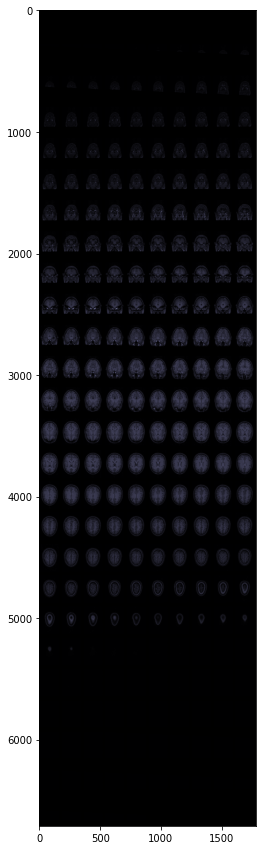

In [12]:
# Viz
TensorDicom3D.create(d.images[0]).show()

In [9]:
# add metadata
def lookup_metadata(img_path):
    sz, sp = data_df.loc[data_df["fn_base"] == os.path.basename(img_path)][["sz", "sp"]].values[0]
    return sz, sp

In [43]:
# which sizes are represented?
szs, spcs = zip(*[lookup_metadata(img_path) for img_path in d["images"].tolist()])
unique_szs  = set(szs)
unique_spcs = set(spcs)
print(f"Sizes ({len(szs)}): ", *list(unique_szs)[:10], sep="\n")
print(f"Spacings ({len(spcs)}): ", *list(unique_spcs)[:10], sep="\n")

unique, idxs, cnts = np.unique(spcs, return_index=True, return_inverse=False, return_counts=True, axis=0print(unique)
print(unique)
print(idxs)
print(cnts)

Sizes (29): 
(176, 256, 256)
(160, 480, 512)
Spacings (29): 
(1.2, 0.5, 0.5)
(1.05, 1.05, 1.05)


# Resize to common dimension

In [91]:
# img data = size and spacing
all_img_data = [lookup_metadata(img_path) for img_path in d["images"].tolist()]

In [92]:
def get_reference_frame(all_img_data):
    img_data = all_img_data
    
    dimension = 3 # 3D MRs
    pixel_id = 2 # 16-bit signed integer

    # Physical image size corresponds to the largest physical size in the training set, or any other arbitrary size.
    reference_physical_size = np.zeros(dimension)

    for img_sz, img_spc in img_data:
        reference_physical_size[:] = [(sz-1)*spc if sz*spc>mx else mx \
                                      for sz, spc, mx in zip(img_sz, img_spc, reference_physical_size)]
    
    # Create the reference image with a zero origin, identity direction cosine matrix and dimension     
    reference_origin = np.zeros(dimension)
    reference_direction = np.identity(dimension).flatten()

    # Isotropic (1,1,1) pixels
    reference_spacing = np.ones(dimension)
    reference_size = [int(phys_sz/(spc) + 1) for phys_sz,spc in zip(reference_physical_size, reference_spacing)]

    # Set reference image attributes
    reference_image = sitk.Image(reference_size, pixel_id)
    reference_image.SetOrigin(reference_origin)
    reference_image.SetSpacing(reference_spacing)
    reference_image.SetDirection(reference_direction)

    reference_center = np.array(reference_image.TransformContinuousIndexToPhysicalPoint(np.array(reference_image.GetSize())/2.0))
    return reference_size, pixel_id, reference_origin, reference_spacing, reference_direction, reference_center

def get_reference_image(reference_frame):
    reference_size, pixel_id, reference_origin, reference_spacing, reference_direction, reference_center = reference_frame
    reference_image = sitk.Image(reference_size, pixel_id)
    reference_image.SetOrigin(reference_origin)
    reference_image.SetSpacing(reference_spacing)
    reference_image.SetDirection(reference_direction)
    return reference_image, reference_center

# Get reference frame
reference_frame = get_reference_frame(all_img_data)
print("Reference frame: ", *reference_frame)

# Get reference image
reference_image, reference_center = get_reference_image(reference_frame)
print("Reference center: ", reference_center)

# Print info on reference image
print_sitk_info(reference_image)

Reference frame:  [191, 268, 268] 2 [0. 0. 0.] [1. 1. 1.] [1. 0. 0. 0. 1. 0. 0. 0. 1.] [ 95.5 134.  134. ]
Reference center:  [ 95.5 134.  134. ]
Size:  (191, 268, 268)
Origin:  (0.0, 0.0, 0.0)
Spacing:  (1.0, 1.0, 1.0)
Direction:  (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Pixel type: 2 = 16-bit signed integer


In [139]:
# removed mask arg
def resample2ref(img, reference_image, reference_center, interpolator = sitk.sitkLinear, default_intensity_value = 0.0, dimension=3):
    
    # Define translation transform mapping origins from reference_image to the current img
    transform = sitk.AffineTransform(dimension)
    transform.SetMatrix(img.GetDirection())
    transform.SetTranslation(np.array(img.GetOrigin()) - reference_image.GetOrigin())
    
    # Modify the transformation to align the centers of the original and reference image instead of their origins.
    centering_transform = sitk.TranslationTransform(dimension)
    img_center = np.array(img.TransformContinuousIndexToPhysicalPoint(np.array(img.GetSize())/2.0))
    centering_transform.SetOffset(np.array(transform.GetInverse().TransformPoint(img_center) - reference_center))
    centered_transform = sitk.Transform(transform)
    centered_transform.AddTransform(centering_transform)
    
    return sitk.Resample(img, reference_image, centered_transform, interpolator, default_intensity_value, img.GetPixelID())

def resample2ref_item(img, mask, reference_image, reference_center, interpolator = sitk.sitkLinear, default_intensity_value = 0.0, dimension=3):
    
    # Define translation transform mapping origins from reference_image to the current img
    transform = sitk.AffineTransform(dimension)
    transform.SetMatrix(img.GetDirection())
    transform.SetTranslation(np.array(img.GetOrigin()) - reference_image.GetOrigin())
    
    # Modify the transformation to align the centers of the original and reference image instead of their origins.
    centering_transform = sitk.TranslationTransform(dimension)
    img_center = np.array(img.TransformContinuousIndexToPhysicalPoint(np.array(img.GetSize())/2.0))
    centering_transform.SetOffset(np.array(transform.GetInverse().TransformPoint(img_center) - reference_center))
    centered_transform = sitk.Transform(transform)
    centered_transform.AddTransform(centering_transform)
    
    objs    = img, mask
    interps = interpolator, sitk.sitkNearestNeighbor
    return [sitk.Resample(o, reference_image, centered_transform, interp, default_intensity_value, o.GetPixelID()) for o,interp in zip(objs, interps)]

In [140]:
from helpers_preprocess import folder2objs

class SlicerSegmentationTransform(ItemTransform):
    def __init__(self, data_dict):
        self.data_dict = data_dict
        
    def encodes(self, x):
        obj_path, img_path = x
        folder = Path(obj_path).parent.name
        ras_adj = int(folder) in range(50455, 50464)
        img_obj, mask_obj = folder2objs(folder, self.data_dict, ras_adj)
        return img_obj, mask_obj
    
# class Sitk2Tensir(Transform):
#     def encodes(self, x): return TensorDicom3D.

In [141]:
# http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/05_Results_Visualization.html
def make_isotropic(image, new_spacing = 1, interpolator = sitk.sitkLinear):
    '''
    Resample an image to isotropic pixels (using smallest spacing from original) and save to file. Many file formats 
    (jpg, png,...) expect the pixels to be isotropic. By default the function uses a linear interpolator. For
    label images one should use the sitkNearestNeighbor interpolator so as not to introduce non-existant labels.
    '''
    
    # Make image isotropic via resampling.
    original_size = image.GetSize()
    original_spacing = image.GetSpacing()
    
    new_size = [int(round(osz*ospc/new_spacing)) for osz,ospc in zip(original_size, original_spacing)]
    new_spacing = [new_spacing]*image.GetDimension()
    
    return sitk.Resample(image, new_size, sitk.Transform(), interpolator,
                         image.GetOrigin(), new_spacing, image.GetDirection(), 0,
                         image.GetPixelID())

In [116]:
# test make isotropic: using F.interpolate vs sitk

file = d["images"][0]

a = TensorDicom3D.create(file)
b = a.size_correction(new_spacing=1)
# p =  PreprocessDicom(correct_spacing=True, spacing = 1)
# b = p(a)
print(type(a), a.shape)
print(type(b), b.shape)

a1 = sitk.ReadImage(file, sitk.sitkFloat32)
b1 = make_isotropic(a1)

print(a1.GetSize(), b1.GetSize())

<class 'faimed3d.basics.TensorDicom3D'> (256, 256, 176)
<class 'faimed3d.basics.TensorDicom3D'> (256, 243, 167)
(176, 256, 256) (185, 269, 269)


In [115]:
# test make isotropic: using F.interpolate vs sitk

file = d["images"][1]

a = TensorDicom3D.create(file)
b = a.size_correction(new_spacing=1)
# p =  PreprocessDicom(correct_spacing=True, spacing = 1)
# b = p(a)
print(type(a), a.shape)
print(type(b), b.shape)

a1 = sitk.ReadImage(file, sitk.sitkFloat32)
b1 = make_isotropic(a1)

print(a1.GetSize(), b1.GetSize())

<class 'faimed3d.basics.TensorDicom3D'> (512, 480, 160)
<class 'faimed3d.basics.TensorDicom3D'> (512, 400, 133)
(160, 480, 512) (192, 240, 256)


In [142]:
from helpers_preprocess import folder2objs

class SlicerSegmentationTransform(ItemTransform):
    def __init__(self, data_dict):
        self.data_dict = data_dict
        
    def encodes(self, x):
        obj_path, img_path = x
        folder = Path(obj_path).parent.name
        ras_adj = int(folder) in range(50455, 50464)
        return folder2objs(folder, self.data_dict, ras_adj)
        #img_obj, mask_obj = folder2objs(folder, self.data_dict, ras_adj)
        #return TensorDicom3D(img_obj), TensorDicom3D(mask_obj) 
    
class IsotropicTransform(ItemTransform):
    def encodes(self, x):
        img, mask = x
        return  make_isotropic(img, new_spacing = 1, interpolator = sitk.sitkLinear), \
                make_isotropic(img, new_spacing = 1, interpolator = sitk.sitkNearestNeighbor)

class Resample2Ref(ItemTransform):
    def __init__(self, reference_image, reference_center):
        self.ref_im   = reference_image
        self.ref_cntr = reference_center
        
    def encodes(self, x):
        im, mask = x
        return resample2ref_item(im, mask, self.ref_im, self.ref_cntr)
    
class ToTensor3D(ItemTransform):
    def encodes(self, x):
        im, mask = x
        return torch.tensor(sitk.GetArrayFromImage(im)), torch.tensor(sitk.GetArrayFromImage(mask))

In [ ]:
items = list(train_data_dict.values())
print("Items: ", *items[:5], sep="\n")

tls = TfmdLists(items, [SlicerSegmentationTransform(train_data_dict), IsotropicTransform, ToTensor3D])

In [143]:
items = list(train_data_dict.values())
print("Items: ", *items[:5], sep="\n")

tls = TfmdLists(items, [SlicerSegmentationTransform(train_data_dict), Resample2Ref(reference_image, reference_center), ToTensor3D])

Items: 
('./train_data/train_data/50049/Segmentation.obj', './train_data/train_data/50049/MP-RAGE/2000-01-01_00_00_00.0/S164545/ABIDE_50049_MRI_MP-RAGE_br_raw_20120830165423769_S164545_I328548.nii')
('./train_data/train_data/50455/Segmentation.obj', './train_data/train_data/50455/MP-RAGE/2000-01-01_00_00_00.0/S165455/ABIDE_50455_MRI_MP-RAGE_br_raw_20120831000745302_S165455_I329465.nii')
('./train_data/train_data/50458/Segmentation.obj', './train_data/train_data/50458/MP-RAGE/2000-01-01_00_00_00.0/S165212/ABIDE_50458_MRI_MP-RAGE_br_raw_20120830215600956_S165212_I329222.nii')
('./train_data/train_data/50461/Segmentation.obj', './train_data/train_data/50461/MP-RAGE/2000-01-01_00_00_00.0/S165203/ABIDE_50461_MRI_MP-RAGE_br_raw_20120830215105276_S165203_I329213.nii')
('./train_data/train_data/50013/Segmentation.obj', './train_data/train_data/50013/MP-RAGE/2000-01-01_00_00_00.0/S165376/ABIDE_50013_MRI_MP-RAGE_br_raw_20120830232151169_S165376_I329386.nii')


In [144]:
dls = tls.dataloaders(bs=2)

In [146]:
b = dls.one_batch()

In [148]:
type(b), b[0].shape, b[1].shape

(tuple, torch.Size([2, 268, 268, 191]), torch.Size([2, 268, 268, 191]))

In [149]:
def dice(input, target):
    iflat = input.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()
    return ((2. * intersection) /
           (iflat.sum() + tflat.sum()))

def dice_score(input, target):
    return dice(input.argmax(1), target)

def dice_loss(input, target): 
    return 1 - dice(input.softmax(1)[:, 1], target)

def loss(input, target):
    return dice_loss(input, target) + nn.CrossEntropyLoss()(input, target[:, 0])

In [ ]:
learn = unet_learner_3d(dls, r3d_18, n_out=2, 
                        loss_func = loss,
                        metrics = dice_score,
                        model_dir = ".",
                        cbs = [SaveModelCallback(monitor='dice_score')]
                       )
learn = learn.to_fp16()

Downloading: "https://download.pytorch.org/models/r3d_18-b3b3357e.pth" to /home/rgologorsky/.cache/torch/hub/checkpoints/r3d_18-b3b3357e.pth


  0%|          | 0.00/127M [00:00<?, ?B/s]

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(3, 0.01, wd = 1e-4)


In [88]:
after_item  = [TensorDicom3D, MaxScale(), resample]
after_batch = []

In [121]:
# df cols = masks, images, is_valid
splitter = ColSplitter(2)

# item tfms
rescale_method = MaxScale()
resample = Resample3D(size=(191, 268, 268),
                      spacing=(1,1,1),
                      origin=(0,0,0),
                      direction=(1,0,0,\
                                 0,1,0,\
                                 0,0,1))

items = list(train_data_dict.values())
tls = TfmdLists(items, [SlicerSegmentationTransform(train_data_dict), IsotropicTransform])

# batch_tfms=[PreprocessDicom(**kwargs)])
# item_tfms=AddMaskCodes(codes=codes))

AttributeError: module 'SimpleITK' has no attribute 'itkNearestNeighbor'

In [89]:
dls = tls.dataloaders(bs=2)

Could not do one pass in your dataloader, there is something wrong in it


In [91]:
Pipeline(after_item)

TypeError: __new__() missing 1 required positional argument: 'x'

In [83]:
a,b = tls[0]

In [84]:
t1 = TensorDicom3D.from_sitk(a)

In [86]:
t1

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 

In [ ]:
TensorDicom3D.from_sitk(a)

In [67]:
show_at(tls.train, 0)

In [73]:
type(tls.train[0])

tuple

In [68]:
a,b = tls.train[0]

In [72]:
type(a[0])

torch.Tensor

In [54]:
# batch tfms
batch_tfms = [AddChannel(), \
              RandomPerspective3D(input_size=268, p=0.5, distortion_scale=0.25), 
              *aug_transforms_3d(p_all=0.15, noise=False)]

# dblock
dblock = DataBlock(blocks=(ImageBlock3D(cls=TensorDicom3D),MaskBlock3D(codes=None)),
                           get_x=ColReader(0),
                           get_y=ColReader(1),
                           splitter=splitter,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms,
                           n_inp = 1)

In [57]:
dls = dblock.dataloaders(d)

RuntimeError: Exception thrown in SimpleITK ReadImage: /home/francesco/SimpleElastix/Code/IO/src/sitkImageReaderBase.cxx:107:
sitk::ERROR: Unable to determine ImageIO reader for "train_data/train_data/50049/Segmentation.obj"

In [53]:
DataLoaders.from_dblock(
    dblock,
    source,
    path='.',
    bs=64,
    val_bs=None,
    shuffle_train=True,
    device=None,
    **kwargs,
)

In [21]:
# https://github.com/kbressem/faimed3d/blob/deada354a1ead1341f1578f84ab6325c50be56ca/faimed3d/augment.py
dls = SegmentationDataLoaders3D.from_df(d, path = '.',
                                item_tfms =Resample3D(size=(191, 268, 268),
                                                      spacing=(1,1,1),
                                                      origin=(0,0,0),
                                                      direction=(1,0,0,\
                                                                 0,1,0,\
                                                                 0,0,1)),
                                batch_tfms = [RandomPerspective3D(input_size=268, p=0.5, distortion_scale=0.25), 
                                              *aug_transforms_3d(p_all=0.15, noise=False)],
                                bs = 1, 
                                val_bs = 1,
                                splitter = ColSplitter('is_valid'))

RuntimeError: Exception thrown in SimpleITK ReadImage: /home/francesco/SimpleElastix/Code/IO/src/sitkImageReaderBase.cxx:107:
sitk::ERROR: Unable to determine ImageIO reader for "train_data/train_data/50463/Segmentation.obj"

In [51]:
DataLoaders.from_dblock??

In [82]:
path  = "./train_data/train_data/50461/MP-RAGE/2000-01-01_00_00_00.0/S165203/ABIDE_50461_MRI_MP-RAGE_br_raw_20120830215105276_S165203_I329213.nii"
sitk.ReadImage(path, sitk.sitkFloat32)

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7fd77923cd50> >

In [81]:
sitk.ReadImage??

In [ ]:
# dls = SegmentationDataLoaders3D.from_df(d,
#                                  item_tfms = Resize3D((20, 112, 112)),
#                                  batch_tfms = aug_transforms_3d(), 
#                                  bs = 2, val_bs = 2)

In [66]:
RandomPerspective3D??

In [ ]:
dls = SegmentationDataLoaders3D.from_df(d, path = '/',
                                item_tfms = ResizeCrop3D((0, 0, 0), (20, 224, 224)), 
                                batch_tfms = [RandomPerspective3D(224, 0.5), 
                                              *aug_transforms_3d(p_all=0.15, noise=False)],
                                bs = 1, 
                                val_bs = 1,
                                splitter = ColSplitter('is_valid'))

In [ ]:
def dice(input, target):
    iflat = input.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()
    return ((2. * intersection) /
           (iflat.sum() + tflat.sum()))

def dice_score(input, target):
    return dice(input.argmax(1), target)

def dice_loss(input, target): 
    return 1 - dice(input.softmax(1)[:, 1], target)

def loss(input, target):
    return dice_loss(input, target) + nn.CrossEntropyLoss()(input, target[:, 0])

In [ ]:
learn = unet_learner_3d(dls, r3d_18, n_out=2, 
                        loss_func = loss,
                        metrics = dice_score,
                        model_dir = REPO_DIR/'models',
                        cbs = [SaveModelCallback(monitor='dice_score')]
                       )
learn = learn.to_fp16()

In [ ]:
learn.lr_find()


In [ ]:
learn.fit_one_cycle(3, 0.01, wd = 1e-4)

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(50, 1e-3, wd = 1e-4)

# Resize to common dimension

In [15]:
# img data = size and spacing
all_img_data = [lookup_metadata(img_path) for img_path in d["images"].tolist()]

In [16]:
def get_reference_frame(all_img_data):
    img_data = all_img_data
    
    dimension = 3 # 3D MRs
    pixel_id = 2 # 16-bit signed integer

    # Physical image size corresponds to the largest physical size in the training set, or any other arbitrary size.
    reference_physical_size = np.zeros(dimension)

    for img_sz, img_spc in img_data:
        reference_physical_size[:] = [(sz-1)*spc if sz*spc>mx else mx \
                                      for sz, spc, mx in zip(img_sz, img_spc, reference_physical_size)]
    
    # Create the reference image with a zero origin, identity direction cosine matrix and dimension     
    reference_origin = np.zeros(dimension)
    reference_direction = np.identity(dimension).flatten()

    # Isotropic (1,1,1) pixels
    reference_spacing = np.ones(dimension)
    reference_size = [int(phys_sz/(spc) + 1) for phys_sz,spc in zip(reference_physical_size, reference_spacing)]

    # Set reference image attributes
    reference_image = sitk.Image(reference_size, pixel_id)
    reference_image.SetOrigin(reference_origin)
    reference_image.SetSpacing(reference_spacing)
    reference_image.SetDirection(reference_direction)

    reference_center = np.array(reference_image.TransformContinuousIndexToPhysicalPoint(np.array(reference_image.GetSize())/2.0))
    return reference_size, pixel_id, reference_origin, reference_spacing, reference_direction, reference_center

def get_reference_image(reference_frame):
    reference_size, pixel_id, reference_origin, reference_spacing, reference_direction, reference_center = reference_frame
    reference_image = sitk.Image(reference_size, pixel_id)
    reference_image.SetOrigin(reference_origin)
    reference_image.SetSpacing(reference_spacing)
    reference_image.SetDirection(reference_direction)
    return reference_image, reference_center

# Get reference frame
reference_frame = get_reference_frame(all_img_data)
print("Reference frame: ", *reference_frame)

# Get reference image
reference_image, reference_center = get_reference_image(reference_frame)
print("Reference center: ", reference_center)

# Print info on reference image
print_sitk_info(reference_image)

Reference frame:  [191, 268, 268] 2 [0. 0. 0.] [1. 1. 1.] [1. 0. 0. 0. 1. 0. 0. 0. 1.] [ 95.5 134.  134. ]
Reference center:  [ 95.5 134.  134. ]
Size:  (191, 268, 268)
Origin:  (0.0, 0.0, 0.0)
Spacing:  (1.0, 1.0, 1.0)
Direction:  (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Pixel type: 2 = 16-bit signed integer


In [17]:
# removed mask arg
def resample2ref(img, reference_image, reference_center, interpolator = sitk.sitkLinear, default_intensity_value = 0.0, dimension=3):
    
    # Define translation transform mapping origins from reference_image to the current img
    transform = sitk.AffineTransform(dimension)
    transform.SetMatrix(img.GetDirection())
    transform.SetTranslation(np.array(img.GetOrigin()) - reference_image.GetOrigin())
    
    # Modify the transformation to align the centers of the original and reference image instead of their origins.
    centering_transform = sitk.TranslationTransform(dimension)
    img_center = np.array(img.TransformContinuousIndexToPhysicalPoint(np.array(img.GetSize())/2.0))
    centering_transform.SetOffset(np.array(transform.GetInverse().TransformPoint(img_center) - reference_center))
    centered_transform = sitk.Transform(transform)
    centered_transform.AddTransform(centering_transform)
    
    return sitk.Resample(img, reference_image, centered_transform, interpolator, default_intensity_value, o.GetPixelID())

In [19]:
# dls = SegmentationDataLoaders3D.from_df(d, path = '/',
#                                 item_tfms = ResizeCrop3D((0, 0, 0), (20, 224, 224)), 
#                                 batch_tfms = [RandomPerspective3D(224, 0.5), 
#                                               *aug_transforms_3d(p_all=0.15, noise=False)],
#                                 bs = 1, 
#                                 val_bs = 1,
#                                 splitter = ColSplitter('is_valid'))

In [20]:
# Resample3D(RandTransform):
#     split_idx,order = None, 1
#     "Resamples a sitk.Image to an new size, origin, spacing and direction."

#     def __init__(self, size:tuple, spacing:tuple, origin:tuple=None,  direction:tuple=None,p=1, **kwargs):